In [1]:
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import io
import requests
import pandas as pd
from pathlib import Path

In [2]:
### This is the local file path, but we decided to use an S3 bucket instead
# readpath = Path.cwd() / 'Data' / 'heart_failure_clinical_records_dataset.csv'
url="https://final-project-heart.s3.amazonaws.com/heart_failure_clinical_records_dataset.csv"
s=requests.get(url).content
df = pd.read_csv(io.StringIO(s.decode('utf-8')))

In [3]:
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


### Formatting Dataset for Models

In [36]:
target = df["DEATH_EVENT"]
target_names = ["living", "deceased"]
data = df.drop("DEATH_EVENT", axis=1)
feature_names = data.columns
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8


In [7]:
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=3)

### Random Forest Classifier

In [20]:
train = []
test = []
for x in range(10):
    RF_classifier = RandomForestClassifier(n_estimators=x+1)
    RF_classifier.fit(X_train, y_train)
    train.append(RF_classifier.score(X_train, y_train))
    test.append(RF_classifier.score(X_test, y_test))
    print(f"Number of Estimators: {x+1}")

Number of Estimators: 1
Number of Estimators: 2
Number of Estimators: 3
Number of Estimators: 4
Number of Estimators: 5
Number of Estimators: 6
Number of Estimators: 7
Number of Estimators: 8
Number of Estimators: 9
Number of Estimators: 10


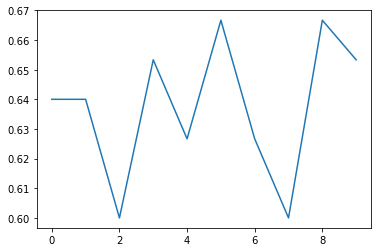

In [35]:
plt.plot(test)
test_df = pd.DataFrame(data=test)
test_df.to_csv('./Data/random_forest_sensitivity.csv')

### Sensitivity Study
Iterated over 0 to 300 estimators to find the what would yield the best model. It appears to reach a limit around 50 estimators, but we chose to go after the spike at 88 estimators for our model using all features. 

In [10]:
rf = RandomForestClassifier(n_estimators=88)
rf = rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.8133333333333334

In [11]:
sorted(zip(rf.feature_importances_, feature_names), reverse=True)

[(0.3815366336280393, 'time'),
 (0.13258949887442803, 'serum_creatinine'),
 (0.11514937037402272, 'ejection_fraction'),
 (0.09192441495834806, 'age'),
 (0.07820962124989896, 'creatinine_phosphokinase'),
 (0.07446235053435081, 'serum_sodium'),
 (0.07133886005045988, 'platelets'),
 (0.012510576122562672, 'diabetes'),
 (0.011518699708605092, 'smoking'),
 (0.011498979424806516, 'high_blood_pressure'),
 (0.010831924024036176, 'sex'),
 (0.00842907105044178, 'anaemia')]

### All Features Classification Report

In [33]:
predictions = rf.predict(X_test)
report = classification_report(y_test, predictions, target_names=target_names, output_dict=True)
rf_report = pd.DataFrame(report).T
rf_report.to_html('./templates/random_forest_all_features_report.html')
rf_report.head()

,precision,recall,f1-score,support
living,0.714286,0.754717,0.733945,53.000000
deceased,0.315789,0.272727,0.292683,22.000000
accuracy,0.613333,0.613333,0.613333,0.613333
macro avg,0.515038,0.513722,0.513314,75.000000
weighted avg,0.597393,0.613333,0.604508,75.000000


### Using only patient-known factors

In [23]:
patient_known_data = df.drop(["time","creatinine_phosphokinase", "ejection_fraction", "platelets", "serum_creatinine", "serum_sodium", "DEATH_EVENT"], axis=1)
feature_names = patient_known_data.columns
patient_known_data.head()

,age,anaemia,diabetes,high_blood_pressure,sex,smoking
0,75.0,0,0,1,1,0
1,55.0,0,0,0,1,0
2,65.0,0,0,0,1,1
3,50.0,1,0,0,1,0
4,65.0,1,1,0,0,0


In [24]:
X_train, X_test, y_train, y_test = train_test_split(patient_known_data, target, random_state=5)

In [25]:
rf = RandomForestClassifier(n_estimators=88)
rf = rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.6133333333333333

In [26]:
sorted(zip(rf.feature_importances_, feature_names), reverse=True)

[(0.7184836440603929, 'age'),
 (0.05953650889692783, 'diabetes'),
 (0.05801875034133296, 'sex'),
 (0.05672038058360871, 'smoking'),
 (0.05649676772714986, 'anaemia'),
 (0.05074394839058781, 'high_blood_pressure')]

### Patient-known Features Classification Report

In [32]:
predictions = rf.predict(X_test)
report = classification_report(y_test, predictions, target_names=target_names, output_dict=True)
rf_report = pd.DataFrame(report).T
rf_report.to_html('./templates/random_forest_patient_known_features_report.html')
rf_report.head()

,precision,recall,f1-score,support
living,0.714286,0.754717,0.733945,53.000000
deceased,0.315789,0.272727,0.292683,22.000000
accuracy,0.613333,0.613333,0.613333,0.613333
macro avg,0.515038,0.513722,0.513314,75.000000
weighted avg,0.597393,0.613333,0.604508,75.000000
